## Credit Card Fraud Analysis

### Business Problem

The Credit Card Fraud Detection Problem includes modeling past credit card transactions with the knowledge of the ones that turned out to be fraud. This model is then used to identify whether a new transaction is fraudulent or not. Our aim here is to detect 100% of the fraudulent transactions while minimizing the incorrect fraud classifications.

### Anomaly Detection

Anomaly detection is a technique used to identify unusual patterns that do not conform to expected behavior, called outliers.<br>

Anomalies can be broadly categorized as:

1. Point anomalies: A single instance of data is anomalous if it's too far off from the rest. Business use case: Detecting credit card fraud based on "amount spent."

2. Contextual anomalies: The abnormality is context specific. This type of anomaly is common in time-series data. Business use case: Spending 100 dollars on food every day during the holiday season is normal, but may be odd otherwise.

3. Collective anomalies: A set of data instances collectively helps in detecting anomalies. Business use case: Someone is trying to copy data form a remote machine to a local host unexpectedly, an anomaly that would be flagged as a potential cyber attack.

### Anomaly Detection Techniques

***Clustering-Based Anomaly Detection***
Clustering is one of the most popular concepts in the domain of unsupervised learning.<br>

Assumption: Data points that are similar tend to belong to similar groups or clusters, as determined by their distance from local centroids.<br>

K-means is a widely used clustering algorithm. It creates 'k' similar clusters of data points. Data instances that fall outside of these groups could potentially be marked as anomalies.


In [36]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline

#### Load Data

There are 984 unique credit cards. There are no missing values in the dataset.

In [3]:
info = pd.read_csv("cc_info.csv")
info.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [4]:
info.shape

(984, 5)

In [3]:
info.describe()

,credit_card,zipcode,credit_card_limit
count,9.840000e+02,984.000000,984.000000
mean,5.410432e+15,17895.316057,12321.138211
std,2.545234e+15,23778.651105,7398.449174
min,1.003715e+15,690.000000,2000.000000
25%,3.316062e+15,3280.000000,7000.000000
50%,5.365218e+15,5820.000000,10000.000000
75%,7.562153e+15,18101.250000,16000.000000
max,9.999757e+15,98401.000000,55000.000000


In [5]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   credit_card        984 non-null    int64 
 1   city               984 non-null    object
 2   state              984 non-null    object
 3   zipcode            984 non-null    int64 
 4   credit_card_limit  984 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 38.6+ KB


In [6]:
info.isnull().sum()

credit_card          0
city                 0
state                0
zipcode              0
credit_card_limit    0
dtype: int64

There are 294588 unique credit card transactions. Dataset has no missing values.

In [7]:
trnx = pd.read_csv("transactions.csv",parse_dates = ['date'])
trnx.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [8]:
trnx.shape

(294588, 5)

In [9]:
trnx.describe()

,credit_card,transaction_dollar_amount,Long,Lat
count,2.945880e+05,294588.000000,294588.000000,294588.000000
mean,5.424562e+15,86.008036,-76.235238,40.937669
std,2.555803e+15,124.655954,20.135015,5.391695
min,1.003715e+15,0.010000,-179.392887,-68.046553
25%,3.344214e+15,29.970000,-80.209708,40.487726
50%,5.353426e+15,58.470000,-73.199737,42.403066
75%,7.646245e+15,100.400000,-72.091933,43.180015
max,9.999757e+15,999.970000,179.917513,78.914330


In [10]:
trnx.isnull().sum()

credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
dtype: int64

We will merge credit card info with the transactions data to get a full picture of the dataset.

In [11]:
final = pd.merge(left =trnx, right =info, on = 'credit_card', how = 'left')
final.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000


In [12]:
final.shape

(294588, 9)

### Exploratory Analysis

#### Question 1: 
Identify those users that never went above the monthly credit card limit (calendar month). 
The goal of this is to automatically increase their limit.

Let's extract a few date columns

In [13]:
final['month'] = final['date'].dt.month
final['day'] = final['date'].dt.day
final['weekday'] = final['date'].dt.dayofweek 
final['hour'] = final['date'].dt.hour

In [14]:
final.rename(columns={'month':'month'},inplace = True)
final.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9,11,4,0
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10,24,5,22
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10,26,0,18
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10,22,3,19
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10,26,0,20


In [15]:
def limit_exceed(df):
        grp = df.agg({'transaction_dollar_amount':'sum','credit_card_limit':'max'})
        return(grp)


In [17]:
grouped = final.groupby(['credit_card','month']).apply(limit_exceed)


grouped = grouped.reset_index()
grouped

,credit_card,month,transaction_dollar_amount,credit_card_limit
0,1003715054175576,7,162.56,20000.0
1,1003715054175576,8,8441.51,20000.0
2,1003715054175576,9,11281.56,20000.0
3,1003715054175576,10,8954.21,20000.0
4,1013870087888817,7,281.43,15000.0
...,...,...,...,...
3792,9986135779184360,10,11796.95,14000.0
3793,9999757432802760,7,77.59,6000.0
3794,9999757432802760,8,4408.83,6000.0
3795,9999757432802760,9,6814.72,6000.0


In [18]:
grouped['exceed'] = (grouped['transaction_dollar_amount'] > grouped['credit_card_limit']).astype(int)
grouped_sum = grouped.groupby('credit_card')['exceed'].sum().reset_index()
lists = grouped_sum[grouped_sum['exceed'] == 0][['credit_card']]
len(lists)

862

There are 862 credit cards that never exceeded the limit.

In [21]:
lists.head()

,credit_card
0,1003715054175576
1,1013870087888817
2,1023820165155391
3,1073931538936472
4,1077622576192810


#### Question 2

Implement an algorithm that as soon as a user goes above her monthly limit, it triggers an alert so that the user can be notified about that. We assume here that at the beginning of the new month, user total money spent gets reset to zero (i.e. she pays the card fully at the end of each month). Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day.

In [22]:
def above_limit(df,month,day):
    df_filter = df[(df['month'] == month) & (df['day'] <= day)]
    grp = df_filter.groupby('credit_card').apply(limit_exceed)
    grp['exceed'] = (grp['transaction_dollar_amount'] > grp['credit_card_limit']).astype(int)
#grp_sum = grp.groupby('credit_card')['exceed'].sum().reset_index()
    grp_filter = grp[grp['exceed'] > 0][['transaction_dollar_amount','credit_card_limit']]
    return(grp_filter)

In [23]:
above_limit(final,8,20)

,transaction_dollar_amount,credit_card_limit
credit_card,,
2850146878241916,4012.81,4000.0
3936887050542904,5352.07,4000.0
4118286032166087,3416.52,3000.0
4462290711836916,3119.53,2000.0
5723635641134781,2161.30,2000.0
7299183791723634,7074.49,7000.0
7850942767136368,5704.00,4000.0
8522875529951473,5860.89,5000.0
8972201384562696,5266.08,5000.0


### Question 3

Implement an unsupervised algorithm that returns all transactions that seem unusual and are worth being investigated further.<br>
We will use ***Anomaly detection*** method here.

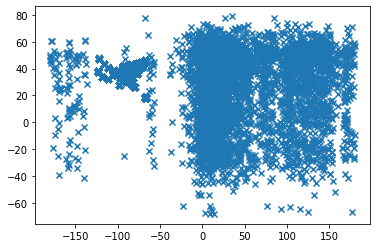

In [24]:
plt.scatter(final['Long'], final['Lat'], marker = "x")

In [25]:
def percentile_amt(s):
    p = [25,50,75]
    d = np.percentile(s,p)
    return(pd.Series(d,index = ['{}%'.format(ps) for ps in p]))

We will divide credit card transaction amount into 25,50 and 75% percentile

In [26]:
tran_stats = final.groupby('credit_card')['transaction_dollar_amount'].apply(percentile_amt).unstack()
tran_stats

,25%,50%,75%
credit_card,,,
1003715054175576,59.0100,93.730,124.630
1013870087888817,58.0900,87.670,128.020
1023820165155391,55.4300,85.780,122.830
1073931538936472,108.0800,147.190,194.830
1077622576192810,122.9300,148.180,160.110
...,...,...,...
9958678964376192,91.3100,145.300,201.560
9961694231875562,43.5500,70.750,104.100
9981251982982618,75.5375,132.615,186.445


In [27]:
temp = pd.merge(left = final, right = tran_stats, on = 'credit_card', how = 'left' )
temp.columns

Index(['credit_card', 'date', 'transaction_dollar_amount', 'Long', 'Lat',
       'city', 'state', 'zipcode', 'credit_card_limit', 'month', 'day',
       'weekday', 'hour', '25%', '50%', '75%'],
      dtype='object')

#### Anomalous activity by transaction amount.

In [28]:
temp_filter = temp[['25%','50%','75%','transaction_dollar_amount','credit_card_limit']]
temp_filter

,25%,50%,75%,transaction_dollar_amount,credit_card_limit
0,59.01,93.73,124.630,43.78,20000
1,59.01,93.73,124.630,103.15,20000
2,59.01,93.73,124.630,48.55,20000
3,59.01,93.73,124.630,136.18,20000
4,59.01,93.73,124.630,71.82,20000
...,...,...,...,...,...
294583,83.74,130.94,177.905,127.23,6000
294584,83.74,130.94,177.905,84.90,6000
294585,83.74,130.94,177.905,77.54,6000
294586,83.74,130.94,177.905,144.05,6000


### Feature Selection Using PCA
We will do PCA Analysis on our dataset so that it is easy to visualize in a 2D space. For PCA we need to first scale our features.

In [29]:
#PCA analysis
temp_norm = scale(temp_filter)

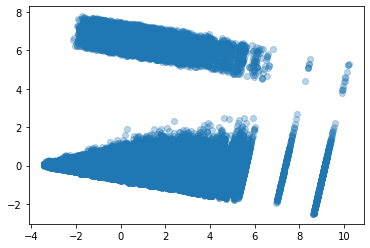

In [30]:
pca = PCA(n_components = 2)
X2d = pca.fit_transform(temp_norm)
X2d = pd.DataFrame(X2d, columns = ['pc1','pc2'])
plt.scatter(X2d.pc1,X2d.pc2,alpha=0.3)

With just 2 components we are able to explain 90% variance.

In [33]:
pca.explained_variance_ratio_.sum()

0.9014562435020235

### K-means Clustering

In [41]:
clusters = [2,4,6,8,10]
inertias = []
silhouettes = []

for n_clusters in clusters:
    print(n_clusters)
    model = KMeans(n_clusters=n_clusters,n_jobs=1)
    label = model.fit(temp_norm)
    
    inertias.append(model.inertia_)
    silhouettes.append(silhouette_score(temp_norm, label.labels_))

2
4
6
8
10


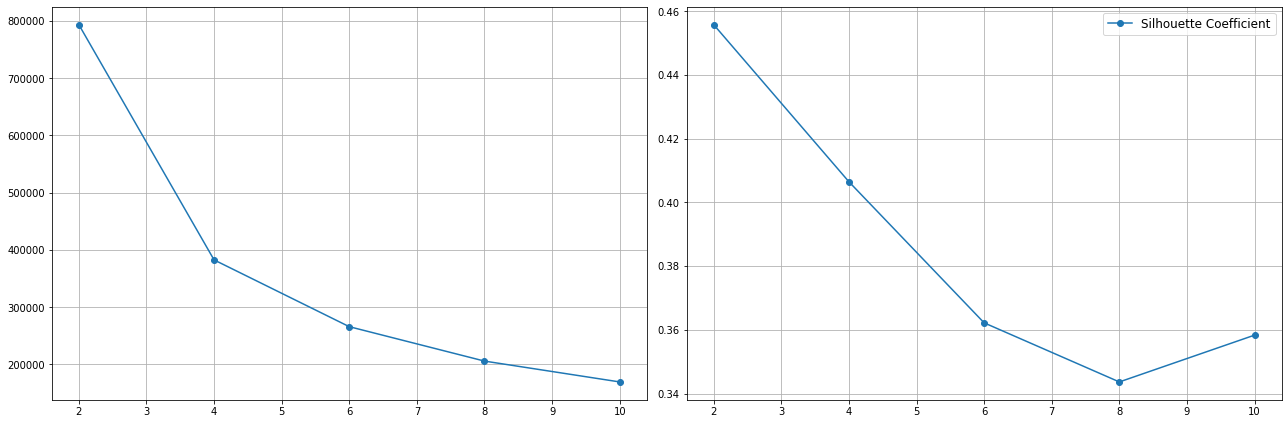

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(clusters, inertias, 'o-', label='Sum of Squared Distances')
ax[0].grid(True)
ax[1].plot(clusters, silhouettes, 'o-', label='Silhouette Coefficient')
ax[1].grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

From the silhouette Coefficient and inertia, it looks like 6 or 8 clusters might be a good option. We can try 6 clusters.

In [43]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters,n_jobs=-1)
kmeans.fit(temp_norm)

X2d['label'] = kmeans.labels_
print(X2d.label.value_counts())

1    107717
0     73558
5     49096
4     33013
2     25768
3      5436
Name: label, dtype: int64


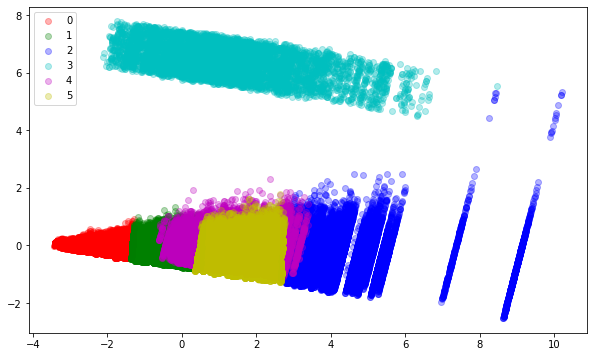

In [48]:
import itertools
colors = itertools.cycle( ['r','g','b','c','m','y','k'] )

plt.figure(figsize=(10,6))
for lab in  range(n_clusters):
    temp1 = X2d.loc[X2d.label == lab,:]
    plt.scatter(temp1.pc1,temp1.pc2,c=next(colors),label=lab,alpha=0.3)

plt.legend(loc='best')

In [46]:
X2d['label'].value_counts()

1    107717
0     73558
5     49096
4     33013
2     25768
3      5436
Name: label, dtype: int64

Cluster 3 has least number of obs. and looks like an anomalous cluster.

In [49]:
suspicious = temp.loc[X2d['label'] == 3]
len(suspicious)

5436

In [50]:
suspicious.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour,25%,50%,75%
84,1003715054175576,2015-09-11 19:50:02,995.35,-80.126760,40.225626,Houston,PA,15342,20000,9,11,4,19,59.01,93.73,124.63
145,1003715054175576,2015-10-01 20:44:09,818.47,-80.279562,40.201031,Houston,PA,15342,20000,10,1,3,20,59.01,93.73,124.63
152,1003715054175576,2015-10-18 01:01:41,888.04,-80.231908,40.297183,Houston,PA,15342,20000,10,18,6,1,59.01,93.73,124.63
226,1003715054175576,2015-08-24 15:14:52,859.31,-80.202474,40.221667,Houston,PA,15342,20000,8,24,0,15,59.01,93.73,124.63
246,1003715054175576,2015-09-24 22:10:07,925.78,-80.164139,40.237733,Houston,PA,15342,20000,9,24,3,22,59.01,93.73,124.63


We can see that the rows marked as suspicious, have a transaction dollar amount which is higher than the usual 75% amount.

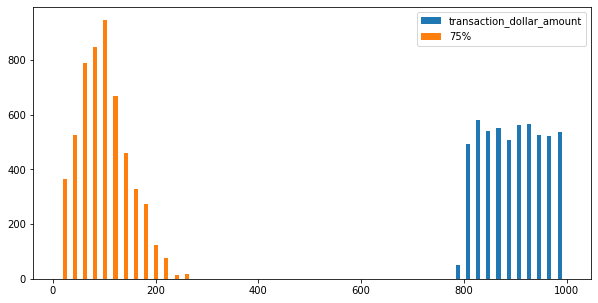

In [54]:
plt.figure(figsize=(10,5))
labels_new = ['transaction_dollar_amount','75%']
plt.hist(suspicious.loc[:,labels_new].values,bins = 50,label=labels_new)
plt.legend(loc='best')

You can see on X-axis that the transction amount is way higher than the 75% percentile so further investigation required.

#### Anomalous activity by distance
Including more features like the distance between median lat long.

In [57]:
address = temp.groupby('credit_card')['Long','Lat'].median().reset_index()
address = address.rename(columns={'Long':'Long_median','Lat':'Lat_median'})
temp = pd.merge(left = temp,right = address, on ='credit_card',how = 'left')
temp.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour,25%,50%,75%,Long_median,Lat_median
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9,11,4,0,59.01,93.73,124.63,-80.210281,40.242914
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10,24,5,22,59.01,93.73,124.63,-80.210281,40.242914
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10,26,0,18,59.01,93.73,124.63,-80.210281,40.242914
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10,22,3,19,59.01,93.73,124.63,-80.210281,40.242914
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10,26,0,20,59.01,93.73,124.63,-80.210281,40.242914


#### Feature Engineering

Adding a new feature called 'distance' which measures distance between every lat/long and lat_median/long_median

In [58]:
temp['distance'] = np.sqrt((temp['Long'] - temp['Long_median'])**2 + (temp['Lat'] - temp['Lat_median'])**2)

In [59]:
temp

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour,25%,50%,75%,Long_median,Lat_median,distance
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9,11,4,0,59.01,93.73,124.630,-80.210281,40.242914,0.043645
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10,24,5,22,59.01,93.73,124.630,-80.210281,40.242914,0.064817
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10,26,0,18,59.01,93.73,124.630,-80.210281,40.242914,0.070094
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10,22,3,19,59.01,93.73,124.630,-80.210281,40.242914,0.060071
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10,26,0,20,59.01,93.73,124.630,-80.210281,40.242914,0.081329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294583,9999757432802760,2015-09-10 19:43:33,127.23,-82.360952,32.978497,Louisville,GA,30434,6000,9,10,3,19,83.74,130.94,177.905,-82.365527,32.997676,0.019718
294584,9999757432802760,2015-08-06 21:00:13,84.90,-82.322721,33.061071,Louisville,GA,30434,6000,8,6,3,21,83.74,130.94,177.905,-82.365527,32.997676,0.076493
294585,9999757432802760,2015-09-22 16:15:47,77.54,-82.442130,32.949983,Louisville,GA,30434,6000,9,22,1,16,83.74,130.94,177.905,-82.365527,32.997676,0.090238
294586,9999757432802760,2015-08-27 18:08:24,144.05,-82.398587,32.976162,Louisville,GA,30434,6000,8,27,3,18,83.74,130.94,177.905,-82.365527,32.997676,0.039444


Filtering dataset to just include distance and credit card transaction amount

In [61]:
lat_filter = temp[['25%','50%','75%','transaction_dollar_amount','credit_card_limit','distance']]
lat_filter.head()

,25%,50%,75%,transaction_dollar_amount,credit_card_limit,distance
0,59.01,93.73,124.63,43.78,20000,0.043645
1,59.01,93.73,124.63,103.15,20000,0.064817
2,59.01,93.73,124.63,48.55,20000,0.070094
3,59.01,93.73,124.63,136.18,20000,0.060071
4,59.01,93.73,124.63,71.82,20000,0.081329


#### PCA Analysis for new dataset

In [63]:
#Scaling
lat_norm = scale(lat_filter)


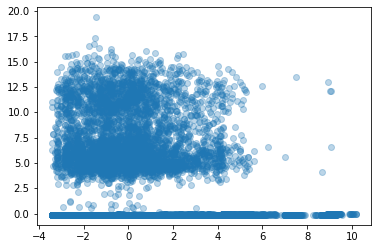

In [64]:
pca = PCA(n_components = 2)
X2d_new = pca.fit_transform(lat_norm)
X2d_new = pd.DataFrame(X2d_new, columns = ['pc1','pc2'])
plt.scatter(X2d_new.pc1,X2d_new.pc2,alpha=0.3)

Again, we will use 6 clusters to look at suspicious activity

In [65]:
n_clusters = 6
kmeans = KMeans(init = 'k-means++',n_clusters=n_clusters,n_jobs=-1)
kmeans.fit(lat_norm)

X2d_new['label'] = kmeans.labels_
print(X2d_new.label.value_counts())

5    112327
0     80895
2     69198
1     22881
3      5396
4      3891
Name: label, dtype: int64


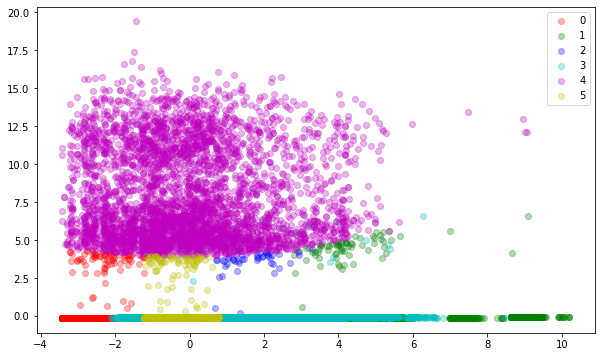

In [66]:
import itertools
colors = itertools.cycle( ['r','g','b','c','m','y','k'] )

plt.figure(figsize=(10,6))
for lab in  range(n_clusters):
    temp1 = X2d_new.loc[X2d_new.label == lab,:]
    plt.scatter(temp1.pc1,temp1.pc2,c=next(colors),label=lab,alpha=0.3)

plt.legend(loc='best')

In [69]:
X2d_new['label'].value_counts()

5    112327
0     80895
2     69198
1     22881
3      5396
4      3891
Name: label, dtype: int64

After including distance metric, we are down to 3891 suspicious transactions. Cluster 4 look like an anomalous cluster.

In [73]:
suspicious_new = temp.loc[X2d_new.label == 4]
len(suspicious_new)

3891

In [74]:
suspicious_new.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour,25%,50%,75%,Long_median,Lat_median,distance
8,1003715054175576,2015-09-17 19:20:37,95.20,-2.833179,34.745015,Houston,PA,15342,20000,9,17,3,19,59.01,93.73,124.63,-80.210281,40.242914,77.572179
14,1003715054175576,2015-09-18 21:44:21,146.75,69.475216,25.125749,Houston,PA,15342,20000,9,18,4,21,59.01,93.73,124.63,-80.210281,40.242914,150.446924
113,1003715054175576,2015-09-08 16:43:42,99.27,34.429275,24.659874,Houston,PA,15342,20000,9,8,1,16,59.01,93.73,124.63,-80.210281,40.242914,115.693816
128,1003715054175576,2015-10-25 00:11:25,87.77,102.032338,-32.343578,Houston,PA,15342,20000,10,25,6,0,59.01,93.73,124.63,-80.210281,40.242914,196.166182
141,1003715054175576,2015-09-25 20:51:42,53.31,-7.373733,-11.785999,Houston,PA,15342,20000,9,25,4,20,59.01,93.73,124.63,-80.210281,40.242914,89.510729


Transactions with higher than 75% amount and longer distances than the mean/median distance 

In [77]:
anomaly = suspicious_new[suspicious_new.transaction_dollar_amount > 2 * (suspicious_new['75%'])]
anomaly.head(10)

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour,25%,50%,75%,Long_median,Lat_median,distance
2948,1126571863414211,2015-10-03 22:57:27,874.30,120.918283,71.915971,Houston,PA,15342,8000,10,3,5,22,10.7300,16.100,22.2000,-80.214646,40.245066,203.611152
6153,1169271395749970,2015-08-06 15:27:27,956.16,95.073584,53.114185,Tampa,FL,33601,20000,8,6,3,15,46.8800,77.580,108.5400,-82.578098,27.996079,179.418615
7907,1210872963953886,2015-10-16 21:19:00,831.31,29.847187,-2.983661,Columbus,NJ,8022,7000,10,16,4,21,44.1800,64.210,84.5900,-74.704657,40.082009,113.074047
21935,1615829389733620,2015-10-03 01:28:51,207.71,108.576256,-10.846429,Washington,NH,3280,14000,10,3,5,1,44.7650,70.470,97.4400,-72.095628,43.176940,188.575858
41595,2238144513466760,2015-09-12 16:23:50,834.37,28.141854,-15.110522,Buffalo,NY,14201,10000,9,12,5,16,19.3475,29.095,41.1675,-78.884744,42.896351,121.735328
42376,2239759218122779,2015-09-25 18:49:11,969.50,107.689153,-5.857321,Washington,NH,3280,20000,9,25,4,18,43.5350,69.070,96.3900,-72.093821,43.171890,186.348547
51571,2600687426901365,2015-08-21 17:07:14,896.10,77.388526,23.440662,Charleston,ME,4422,16000,8,21,4,17,46.8850,74.230,99.3250,-69.035222,45.060472,148.011250
53530,2625359414931381,2015-09-02 02:45:24,852.51,119.507487,36.775800,Washington,NH,3280,12000,9,2,2,2,22.1100,34.970,49.0400,-72.095460,43.173355,191.709723
57028,2800799152896633,2015-10-20 00:53:27,279.34,99.854857,51.487573,Knoxville,PA,16928,25000,10,20,1,0,55.1000,93.850,139.0800,-77.423159,41.952457,177.534260
66491,3138132199016625,2015-10-28 18:02:18,883.70,117.242546,24.566647,Washington,NH,3280,15000,10,28,2,18,37.6800,57.520,79.3850,-72.104592,43.174032,190.259227


In [78]:
len(anomaly)

45

### Results:

1. We can see there are 45 transactions with a dollar amount twice as high as the usual 75% of the transaction amount and much longer distances than the usual mean/median distance. These transactions should be flagged and confirmed with the user.

2. We used K-means clustering for detecting anomalies but there are other methods such as Isolation Forest that could be tried as well.